# Audio Language Model (AWD-LSTM)

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import FastAI Audio modules here:

In [2]:
from audio import *

## Preparing the data

We're going to do **speaker identification** with [the Free ST American English Corpus](http://www.openslr.org/45/ ) data. It's a small-enough, freely-available dataset. 

### Download

Use this file to prep the data. It's a bit more complex than the usual FastAI data setup flow because `untar_data` doesn't accept a filename with a .tgz extension (it adds it itself) and the .tgz file we're using doesn't extract itself into its own directory (sigh). 

In [3]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))

In [4]:
untar_data(data_url, dest = data_folder)

PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

Did we get anything?

In [5]:
data_folder.ls()[:5]

[PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00359.wav'),
 PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00100.wav'),
 PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00381.wav'),
 PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00275.wav'),
 PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00107.wav')]

## Improving Our Model with Data Augmentation

In [6]:
audios = AudioList.from_folder(data_folder); audios

AudioList (3842 items)
REPRESENTATION,REPRESENTATION,REPRESENTATION,REPRESENTATION,REPRESENTATION
Path: /home/h/.fastai/data/ST-AEDS-20180100_1-OS

(array([135., 676., 998., 844., 603., 313., 132.,  69.,  52.,  20.]),
 array([ 26240.,  39616.,  52992.,  66368.,  79744.,  93120., 106496., 119872., 133248., 146624., 160000.]),
 <a list of 10 Patch objects>)

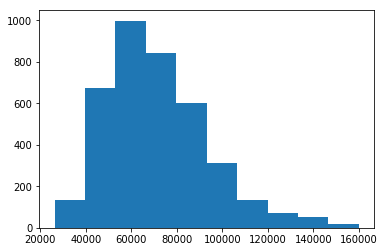

In [7]:
audio_lengths = tensor([a.data.sig.shape[0] for a in audios])
plt.hist(audio_lengths)

In [8]:
tfms = get_audio_transforms(spectro=True,
                            white_noise=True,
                            modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False, mx_to_pad=80000)

In [9]:
## Regex to get the speaker ID in our file name (our label)
label_pattern = r'_([mf]\d+)_'
np.random.seed(2)
data = (audios
        .split_by_rand_pct(0.2)
        .label_from_re(label_pattern)
        .transform(tfms)
        .databunch(bs=50))
data

AudioDataBunch;

Train: LabelList (3074 items)
x: AudioList
REPRESENTATION,REPRESENTATION,REPRESENTATION,REPRESENTATION,REPRESENTATION
y: CategoryList
f0004,m0003,f0002,m0003,f0004
Path: /home/h/.fastai/data/ST-AEDS-20180100_1-OS;

Valid: LabelList (768 items)
x: AudioList
REPRESENTATION,REPRESENTATION,REPRESENTATION,REPRESENTATION,REPRESENTATION
y: CategoryList
f0004,m0002,f0003,m0003,f0002
Path: /home/h/.fastai/data/ST-AEDS-20180100_1-OS;

Test: None

In [10]:
f"Found {data.c} classes, \
{len(data.train_ds)} training samples,\
{len(data.valid_ds)} validation samples"

'Found 10 classes, 3074 training samples,768 validation samples'

In [11]:
data.hear_ex()

f0004


m0002


f0003


In [12]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


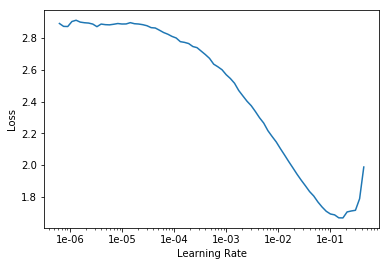

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(10, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.158815,0.592334,0.794271,00:18
1,0.540405,0.311390,0.894531,00:15
2,0.289468,0.221933,0.929688,00:15
3,0.190337,0.090662,0.966146,00:15
4,0.109814,0.174295,0.947917,00:15
5,0.071036,0.127279,0.967448,00:15
6,0.042589,0.060182,0.979167,00:15
7,0.025623,0.041085,0.984375,00:15
8,0.013746,0.041625,0.984375,00:15
9,0.011062,0.050459,0.983073,00:15
